# Mesurer le risque en finance : drawdowns, VaR, ES

Ce chapitre couvre : **courbe de capital**, **drawdowns**, **VaR (historique & paramétrique)**, **Expected Shortfall**, et le **backtesting de la VaR**.


> 1) Tracer la courbe de capital et les drawdowns  
> 2) Estimer la VaR historique (95 % / 99 %)  
> 3) Estimer la VaR paramétrique (gaussienne vs t-Student)  
> 4) Mesurer l’Expected Shortfall (ES / CVaR)  
> 5) Backtester la VaR  

## 0) Préparation

- Assurez-vous d'avoir `yfinance`, `pandas`, `numpy`, `scipy`, `statsmodels`, `matplotlib` installés.


In [1]:
# !pip install yfinance statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t as tdist
import yfinance as yf

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True


## 1) Importer les données (Yahoo Finance)

Vous pouvez ajuster l'univers, les dates et l'indice de marché.  
La **courbe de capital** sera construite sur un **portefeuille équipondéré** .

In [2]:
# --- Paramètres d'import ---
UNIVERSE = ["META","AAPL","MSFT","JPM","BAC","C","XOM","CVX","JNJ","PFE","UNH"]
MARKET_TICKER = "^GSPC"       # S&P 500 (marché)
START_DATE = "2020-01-01"
END_DATE = None               # jusqu'à aujourd'hui

# --- Téléchargement ---
data = yf.download(UNIVERSE + [MARKET_TICKER],
                   start=START_DATE, end=END_DATE,
                   progress=False, auto_adjust=False)

# Extraire les prix ajustés (gère le MultiIndex de yfinance)
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
market_prices = prices[MARKET_TICKER].dropna()
asset_prices  = prices.drop(columns=[MARKET_TICKER], errors="ignore").dropna(how="all")

# Rendements (log)
asset_r  = np.log(asset_prices).diff().dropna(how="all")
market_r = np.log(market_prices).diff().dropna()

asset_prices.tail(), asset_r.tail()


(Ticker            AAPL        BAC           C         CVX         JNJ  \
 Date                                                                    
 2025-09-16  238.149994  50.660000  100.639999  159.539993  176.460007   
 2025-09-17  238.990005  51.400002  101.760002  160.089996  177.199997   
 2025-09-18  237.880005  52.130001  102.410004  158.839996  174.160004   
 2025-09-19  245.500000  52.250000  102.680000  156.210007  176.190002   
 2025-09-22  256.079987  51.919998  103.489998  156.050003  174.210007   
 
 Ticker             JPM        META        MSFT        PFE         UNH  \
 Date                                                                    
 2025-09-16  309.190002  778.474548  509.040009  23.900000  339.779999   
 2025-09-17  311.750000  775.196777  510.019989  24.049999  341.609985   
 2025-09-18  313.230011  779.723755  508.450012  24.150000  334.820007   
 2025-09-19  314.779999  777.854980  517.929993  24.030001  336.690002   
 2025-09-22  312.440002  765.159973 

## 2) Courbe de capital & Drawdowns

- **Courbe de capital (Equity Curve)**  
  Représente l’évolution de la valeur d’un portefeuille au fil du temps  
  (ici, portefeuille équipondéré par défaut).  


- **Drawdown (Perte relative / Retrait relatif)**  
  Mesure la baisse relative par rapport au plus-haut historique atteint par la courbe de capital.  


- **Maximum Drawdown (MDD) / Perte maximale relative**  
  Plus forte perte enregistrée entre un sommet et un creux de la courbe.  


- **Durée maximale de récupération (Maximum Recovery Time / Time Under Water - TUW)**  
  Durée pendant laquelle le portefeuille reste en dessous de son plus-haut historique,  
  jusqu’à ce qu’un nouveau sommet soit atteint.  



In [3]:
# ===============================
# Construction du portefeuille
# ===============================

# Création d'un portefeuille équipondéré (chaque actif a le même poids).
weights = np.repeat(1 / asset_prices.shape[1], asset_prices.shape[1])

# Rendement du portefeuille = combinaison linéaire des rendements des actifs.
port_r = (asset_r @ weights).dropna()

# Courbe de capital (equity curve) = évolution de la valeur du portefeuille.
# On part de 1 et on applique la croissance cumulée des rendements.
equity = (1 + port_r).cumprod()


# ===============================
# Calcul des drawdowns
# ===============================

# HWM (High Water Mark) : plus-haut historique atteint à chaque instant.
hwm = equity.cummax()

# Drawdown = écart relatif entre la valeur courante et le plus-haut historique.
# Négatif ou nul (0 = nouveau sommet).
drawdown = equity / hwm - 1.0


# ===============================
# Calcul du "Time Under Water" (TUW)
# ===============================

# Variable binaire : 1 = en période de récupération (drawdown < 0), 
#                    0 = nouveau sommet historique atteint
temps_recuperation = (drawdown < 0).astype(int)

# Boucle pour mesurer la durée des périodes consécutives de récupération (temps sous le plus-haut historique).
durees_recuperation = []
count = 0
for v in temps_recuperation.values:
    if v == 1:
        count += 1   # toujours en phase de récupération
    else:
        if count > 0:
            durees_recuperation.append(count)  # on enregistre la durée de la période
        count = 0

# Cas où la dernière période de récupération se termine à la fin de la série
if count > 0:
    durees_recuperation.append(count)



# ===============================
# Résultats
# ===============================

# Maximum drawdown (pire perte relative observée)
max_dd = drawdown.min()

# Durée maximale de récupération (temps sous le plus-haut historique, en jours)
max_duree_recuperation = max(durees_recuperation) if durees_recuperation else 0

print(f"Maximum drawdown : {max_dd:.2%}")
print(f"Durée maximale de récupération : {max_duree_recuperation} jours")


Maximum drawdown : -42.23%
Durée maximale de récupération : 512 jours


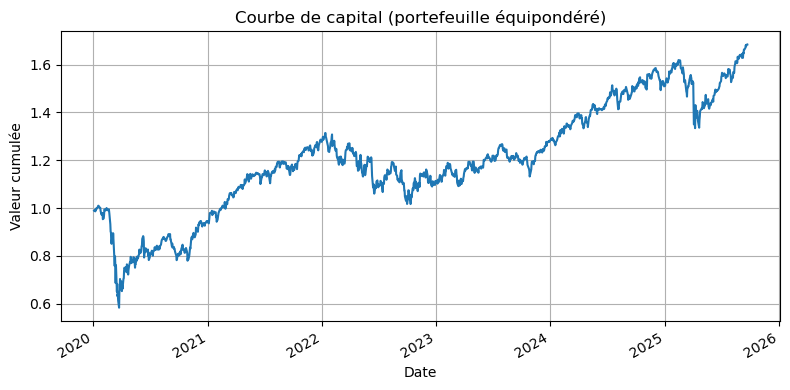

In [4]:
# ===============================
# Graphique 1 : Courbe de capital
# ===============================

plt.figure()
# On trace l’évolution cumulée de la valeur du portefeuille.
equity.plot()
plt.title("Courbe de capital (portefeuille équipondéré)")
plt.xlabel("Date")
plt.ylabel("Valeur cumulée")
# Affiche une visualisation propre et lisible.
plt.tight_layout()
plt.show()

# Interprétation :
# La courbe de capital permet de visualiser la croissance (ou la décroissance)
# du portefeuille au fil du temps. Chaque point correspond à la valeur cumulée
# après réinvestissement des gains/pertes.



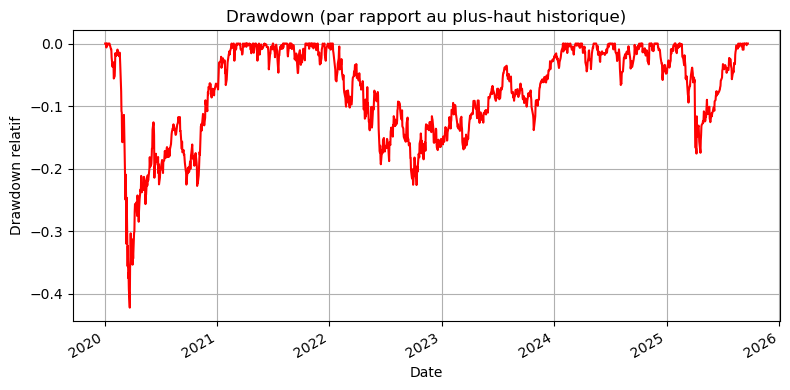

In [5]:


# ===============================
# Graphique 2 : Drawdown
# ===============================

plt.figure()
# On trace le drawdown, i.e. l’écart relatif à chaque instant
# entre la valeur courante et le plus-haut historique.
drawdown.plot(color="red")
plt.title("Drawdown (par rapport au plus-haut historique)")
plt.xlabel("Date")
plt.ylabel("Drawdown relatif")
plt.tight_layout()
plt.show()

#  Interprétation :
# Le drawdown est toujours ≤ 0 :
#   - 0 signifie que le portefeuille est à un nouveau sommet historique.
#   - une valeur négative indique une perte relative.
# Ce graphe met en évidence la profondeur et la durée des périodes de pertes.

## 3) Value-at-Risk (VaR) historique – 95 % / 99 %


La **VaR** mesure la perte maximale attendue d’un portefeuille, pour un horizon donné et un niveau de confiance α.  

- **VaR 95 %** = perte dépassée seulement 5 % du temps.  
- **VaR 99 %** = perte dépassée seulement 1 % du temps.  

### Méthode historique
- On calcule les rendements passés.  
- La VaR correspond au **quantile empirique** des pertes (5 % pour 95 %, 1 % pour 99 %).  

### Exemple
- VaR 95 % = -2 % → "95 % du temps, la perte ne dépassera pas 2 %".  
- VaR 99 % = -3,5 % → "99 % du temps, la perte ne dépassera pas 3,5 %".  

### Limites principales de la VaR historique

1. **Dépendance aux données passées**  
   La VaR historique reflète uniquement l’échantillon utilisé.  

2. **Sous-estimation du risque extrême**  
   Si les données ne contiennent pas de crises ou de chocs importants, la VaR sous-estime le risque réel.  

3. **Pas d’extrapolation possible**  
   La méthode ne permet pas d’évaluer des scénarios jamais observés dans l’historique.




In [9]:
# Paramètres
window = 252  # ~1 an boursier
conf_levels = [0.95, 0.99]
tail = [1 - c for c in conf_levels]

# VaR historique (positive = perte)
var_hist = {}
for c in conf_levels:
    q = 1 - c  # ex: 0.05 pour 95%
    # quantile des rendements (fenêtre t-1), forecast pour t
    v = -port_r.rolling(window).quantile(q).shift(1)
    var_hist[c] = v

var_hist_df = pd.DataFrame(var_hist).rename(columns={0.95: "VaR_H_95", 0.99: "VaR_H_99"})
var_hist_df.tail()

,VaR_H_95,VaR_H_99
Date,,
2025-09-16,0.014211,0.03002
2025-09-17,0.014211,0.03002
2025-09-18,0.014211,0.03002
2025-09-19,0.014211,0.03002
2025-09-22,0.014211,0.03002


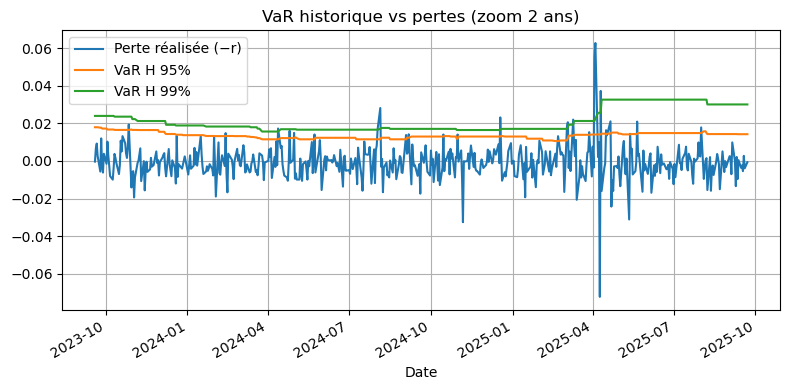

In [10]:
# Plot : VaR historique vs pertes réalisées (zoom dernières 2 années)
last_n = 2 * 252
loss = (-port_r).iloc[-last_n:]  # pertes positives
plt.figure()
loss.plot(label="Perte réalisée (−r)")
var_hist_df.iloc[-last_n:, 0].plot(label="VaR H 95%")
var_hist_df.iloc[-last_n:, 1].plot(label="VaR H 99%")
plt.legend()
plt.title("VaR historique vs pertes (zoom 2 ans)")
plt.tight_layout()
plt.show()

## 4) VaR paramétrique (gaussienne vs t-Student)




## Sous hypothèse normale  

$$
\text{VaR}_{\alpha} = -\left(\mu + z_{1-\alpha}\,\sigma\right)
$$

où :
- $\mu$ = espérance des rendements  
- $\sigma$ = volatilité (écart-type)  
- $z_{1-\alpha}$ = quantile de la loi normale standard (ex. $-1{,}65$ pour 95 %, $-2{,}33$ pour 99 %)



## Sous hypothèse Student-t  
$$
\text{VaR}_{\alpha} = - \big( \text{loc} + \text{scale} \cdot t_{1-\alpha,\;df} \big)
$$  

où :  
- `loc`, `scale`, `df` = paramètres de la loi t-Student (estimés sur une fenêtre glissante),
- **loc** = moyenne des rendements 
- **scale** = volatilité
- $df$ = degrés de liberté de la loi t-Student
  
- $( t_{1-\alpha,\;df} $) = quantile de la loi t-Student avec *df* degrés de liberté.

> Remarque : estimation *t* par `scipy.stats.t.fit` (peut être lente sur de très grandes séries).
>
> La VaR ne dit rien sur l’ampleur des pertes **au-delà du seuil**.

In [13]:
from math import sqrt

# VaR paramétrique Normale (rolling)
mu = port_r.rolling(window).mean().shift(1)
sigma = port_r.rolling(window).std(ddof=1).shift(1)

var_norm = {}
for c in conf_levels:
    a = 1 - c  # queue
    z = norm.ppf(a)   # quantile de gauche (ex: 5% → z négatif)
    v = -(mu + z * sigma)
    var_norm[c] = v

var_norm_df = pd.DataFrame(var_norm).rename(columns={0.95: "VaR_N_95", 0.99: "VaR_N_99"})
var_norm_df.tail()

,VaR_N_95,VaR_N_99
Date,,
2025-09-16,0.017560,0.025083
2025-09-17,0.017561,0.025084
2025-09-18,0.017555,0.025080
2025-09-19,0.017584,0.025104
2025-09-22,0.017584,0.025104


In [12]:
# VaR paramétrique Student-t (rolling fit)

ret = port_r.copy()
idx = ret.index
var_t = {0.95: pd.Series(index=idx, dtype=float),
         0.99: pd.Series(index=idx, dtype=float)}

for i in range(window, len(ret)):
    w = ret.iloc[i-window:i].dropna().values
    if len(w) < window:
        continue
    # Fit t: retourne (df, loc, scale)
    df_t, loc_t, scale_t = tdist.fit(w)
    for c in conf_levels:
        a = 1 - c
        q = tdist.ppf(a, df_t)  # quantile de gauche (négatif)
        v = -(loc_t + scale_t * q)
        var_t[c].iloc[i] = v

var_t_df = pd.concat([var_t[0.95].rename("VaR_T_95"),
                      var_t[0.99].rename("VaR_T_99")], axis=1)
var_t_df.tail()

,VaR_T_95,VaR_T_99
Date,,
2025-09-16,0.013805,0.029132
2025-09-17,0.013808,0.029146
2025-09-18,0.013801,0.029050
2025-09-19,0.013841,0.029180
2025-09-22,0.013841,0.029187


## 5) Expected Shortfall (ES / CVaR)

L’**Expected Shortfall (ES)**, aussi appelé **Conditional VaR (CVaR)**, mesure **la perte moyenne attendue dans les pires cas**, c’est-à-dire au-delà du seuil de la VaR.  
Contrairement à la VaR, l’ES capture non seulement la probabilité d’un dépassement, mais aussi **l’ampleur des pertes extrêmes**.



### Méthodes de calcul

- **Historique**  
  ES = moyenne des pertes situées au-delà de la VaR historique (sur la même fenêtre).

- **Paramétrique (Normale)**  
  $$
  ES = -\left( \mu - \sigma \cdot \frac{\varphi(z)}{\alpha_{\text{tail}}} \right)
  $$  
  où :  
  - $\mu$ = espérance des rendements,  
  - $\sigma$ = volatilité,  
  - $z = \Phi^{-1}(\alpha_{\text{tail}})$ = quantile de la loi normale standard,  
  - $\varphi(z)$ = densité de la loi normale standard,  
  - $\alpha_{\text{tail}} = 1 - \alpha$ (partie en queue).

- **Paramétrique (Student-t)**  
  $$
  ES = -\left( \text{loc} + \text{scale} \cdot 
  \frac{\nu + q^2}{\nu - 1} \cdot \frac{f(q)}{\alpha_{\text{tail}}} \right)
  $$  
  où :  
  - `loc` = moyenne (centrage),  
  - `scale` = volatilité (mise à l’échelle),  
  - $\nu$ = degrés de liberté de la loi t-Student,  
  - $q = t^{-1}(\alpha_{\text{tail}}, \nu)$ = quantile de la loi t,  
  - $f(q)$ = densité de la loi t au point $q$.


### Convention
Par usage en gestion des risques, l’**ES est rendu comme une perte positive** (valeur absolue de la perte attendue).


In [21]:
# ES historique (rolling, one-day-ahead)
def es_historical(r, window, conf=0.95):
    a = 1 - conf
    out = pd.Series(index=r.index, dtype=float)
    for i in range(window, len(r)):
        w = r.iloc[i-window:i].dropna()
        if len(w) < 1:
            continue
        q = w.quantile(a)
        tail_losses = w[w <= q]
        out.iloc[i] = -tail_losses.mean()  # perte positive
    return out

es_hist_95 = es_historical(port_r, window, 0.95)
es_hist_99 = es_historical(port_r, window, 0.99)

In [23]:
es_hist_95

Date
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
2020-01-09         NaN
                ...   
2025-09-16    0.026502
2025-09-17    0.026502
2025-09-18    0.026502
2025-09-19    0.026502
2025-09-22    0.026502
Length: 1437, dtype: float64

In [18]:
# ES Normal (rolling)
def es_normal(mu, sigma, conf=0.95):
    a = 1 - conf
    z = norm.ppf(a)
    phi = norm.pdf(z)
    es = -(mu - sigma * (phi / a))
    return es

es_norm_95 = es_normal(mu, sigma, 0.95)
es_norm_99 = es_normal(mu, sigma, 0.99)

In [24]:
es_norm_95

Date
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
2020-01-09         NaN
                ...   
2025-09-16    0.022173
2025-09-17    0.022174
2025-09-18    0.022169
2025-09-19    0.022195
2025-09-22    0.022195
Length: 1437, dtype: float64

In [26]:

# ES Student-t (rolling, utilise var_t params indirectement via re-fit)
def es_student_series(r, window, conf=0.95):
    a = 1 - conf
    out = pd.Series(index=r.index, dtype=float)
    for i in range(window, len(r)):
        w = r.iloc[i-window:i].dropna().values
        if len(w) < window:
            continue
        df_t, loc_t, scale_t = tdist.fit(w)
        q = tdist.ppf(a, df_t)
        pdf_q = tdist.pdf(q, df_t)
        es = abs(-(loc_t + scale_t * ((df_t + q**2) / (df_t - 1)) * (pdf_q / a)))
        out.iloc[i] = es
    return out

es_t_95 = es_student_series(port_r, window, 0.95)
es_t_99 = es_student_series(port_r, window, 0.99)


In [27]:
es_t_95

Date
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
2020-01-09         NaN
                ...   
2025-09-16    0.026525
2025-09-17    0.026531
2025-09-18    0.026476
2025-09-19    0.026476
2025-09-22    0.026481
Length: 1437, dtype: float64

In [28]:
pd.DataFrame({
    "ES_H_95": es_hist_95,
    "ES_N_95": es_norm_95,
    "ES_T_95": es_t_95
}).tail()

,ES_H_95,ES_N_95,ES_T_95
Date,,,
2025-09-16,0.026502,0.022173,0.026525
2025-09-17,0.026502,0.022174,0.026531
2025-09-18,0.026502,0.022169,0.026476
2025-09-19,0.026502,0.022195,0.026476
2025-09-22,0.026502,0.022195,0.026481


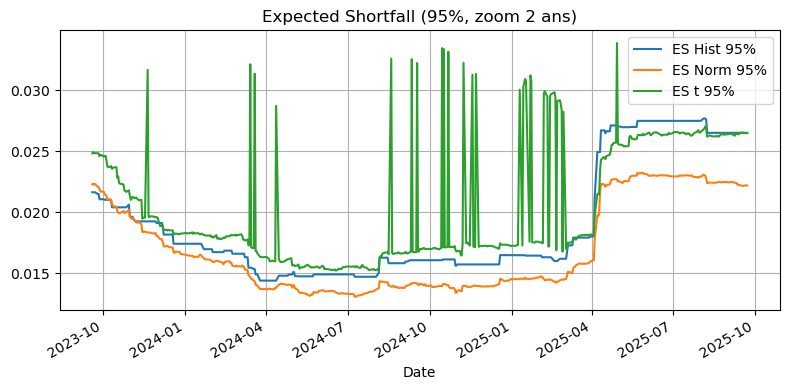

In [29]:
# Plot ES (95%, zoom 2 ans)
last_n = 2 * 252
plt.figure()
es_hist_95.iloc[-last_n:].plot(label="ES Hist 95%")
es_norm_95.iloc[-last_n:].plot(label="ES Norm 95%")
es_t_95.iloc[-last_n:].plot(label="ES t 95%")
plt.legend()
plt.title("Expected Shortfall (95%, zoom 2 ans)")
plt.tight_layout()
plt.show()

## 6) Backtester la VaR  

Le **backtesting** consiste à vérifier si la VaR estimée correspond bien au risque réel observé.  

- On compare le **taux d’exceptions** (jours où la perte dépasse la VaR) avec le **niveau attendu** $(1 - \alpha)$.  
  - Exemple : pour une VaR à 99 %, on s’attend à ≈ 1 exception tous les 100 jours.  

- On applique le **test de Kupiec (POF – Proportion of Failures)**  
  afin de vérifier si le nombre d’exceptions observées est cohérent avec la probabilité théorique.


In [30]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def kupiec_pof_test(loss, var_series, conf=0.95):
    """
    loss: série des pertes POSITIVES (ex: loss = -port_r)
    var_series: VaR rendue en perte POSITIVE et alignée temporellement avec loss
    conf: niveau de confiance (ex: 0.95, 0.99)
    """
    tail = 1 - conf

    # Alignement + nettoyage
    df = pd.concat([loss.rename("loss"), var_series.rename("var")], axis=1).dropna()
    if df.empty:
        return {"N": 0, "x": 0, "rate_obs": np.nan, "rate_exp": tail, "LR_uc": np.nan, "pval": np.nan}

    # Exceptions: pertes qui dépassent la VaR
    x = (df["loss"] > df["var"]).sum()
    N = len(df)

    # Taux observé d'exceptions
    pi_hat = x / N

    # Garde-fou pour éviter log(0) quand pi_hat ∈ {0,1}
    eps = 1e-12
    pi_hat_safe = min(max(pi_hat, eps), 1 - eps)

    # Log-vraisemblances (modèle "correct" vs. "observé")
    ll_null = (N - x) * np.log(1 - tail) + x * np.log(tail)
    ll_hat  = (N - x) * np.log(1 - pi_hat_safe) + x * np.log(pi_hat_safe)

    # Statistique de test de Kupiec (coverage inconditionnel)
    LR_uc = -2 * (ll_null - ll_hat)
    pval  = 1 - chi2.cdf(LR_uc, df=1)

    return {
        "N": int(N),
        "x": int(x),
        "rate_obs": pi_hat,   # proportion d'exceptions observée
        "rate_exp": tail,     # proportion attendue (1 - conf)
        "LR_uc": LR_uc,
        "pval": pval
    }

# -------------------------
# Backtest : HISTORIQUE & NORMALE uniquement
# -------------------------

loss = (-port_r).rename("loss")  # pertes positives

# VaR historique (déjà en pertes positives)
bt_hist_95 = kupiec_pof_test(loss, var_hist_df["VaR_H_95"], conf=0.95)
bt_hist_99 = kupiec_pof_test(loss, var_hist_df["VaR_H_99"], conf=0.99)

# VaR normale (déjà en pertes positives)
bt_norm_95 = kupiec_pof_test(loss, var_norm_df["VaR_N_95"], conf=0.95)
bt_norm_99 = kupiec_pof_test(loss, var_norm_df["VaR_N_99"], conf=0.99)

# Résumé
bt_df = pd.DataFrame(
    [bt_hist_95, bt_hist_99, bt_norm_95, bt_norm_99],
    index=["Hist 95", "Hist 99", "Normal 95", "Normal 99"]
)
bt_df


,N,x,rate_obs,rate_exp,LR_uc,pval
Hist 95,1185,56,0.047257,0.05,0.190996,0.662089
Hist 99,1185,20,0.016878,0.01,4.692927,0.030287
Normal 95,1185,59,0.049789,0.05,0.001112,0.973400
Normal 99,1185,26,0.021941,0.01,12.731332,0.000360


## Résultats du backtesting de la VaR (test de Kupiec)

| Modèle       | N    | x  | Taux observé | Taux attendu | LR_uc   | p-valeur  | Interprétation |
|--------------|------|----|--------------|--------------|---------|-----------|----------------|
| Hist 95 %    | 1185 | 56 | 4,73 %       | 5 %          | 0.191   | 0.662     | Conforme : la VaR historique 95 % couvre correctement le risque. |
| Hist 99 %    | 1185 | 20 | 1,69 %       | 1 %          | 4.693   | 0.030     | Trop d’exceptions → Rejet : la VaR historique 99 % **sous-estime le risque**. |
| Normale 95 % | 1185 | 59 | 4,98 %       | 5 %          | 0.001   | 0.973     | Conforme : la VaR normale 95 % couvre correctement le risque. |
| Normale 99 % | 1185 | 26 | 2,19 %       | 1 %          | 12.731  | 0.00036   | Beaucoup trop d’exceptions → Rejet fort : la VaR normale 99 % **sous-estime fortement le risque**. |

---

###  Conclusion
- À **95 %**, les approches **historique** et **normale** sont cohérentes avec les données (pas de rejet).  
- À **99 %**, les deux approches **sous-estiment le risque**, en particulier la **VaR normale** qui génère bien trop d’exceptions.  
-  En pratique : utiliser des modèles plus adaptés aux **queues épaisses** (par ex. t-Student) et compléter la VaR par l’**Expected Shortfall (ES)** pour mieux capturer les pertes extrêmes.


## 7) Défi — VaR historique 99 % (portefeuille simple, 4 titres)

**Portefeuille (équipondéré)**
- AAPL (25 %)
- MSFT (25 %)
- JPM  (25 %)
- XOM  (25 %)

**Objectif**
Calculez la **Value at Risk (VaR) historique à 99 %** sur **1 jour** pour ce portefeuille, en utilisant une **fenêtre glissante de 252 jours**.

## 8) Solution 

Ci-dessous, une trame **réutilisable** : ajustez `UNIVERSE`, les **poids**, la **fenêtre**, et les **niveaux de confiance** selon votre cas.  
Relisez les **hypothèses** (stationnarité, distributions, indépendance) et testez la **stabilité par sous-périodes**.


Dernière date VaR_99% : 2025-09-22
VaR_99% (historique, 1j) : 3.29%


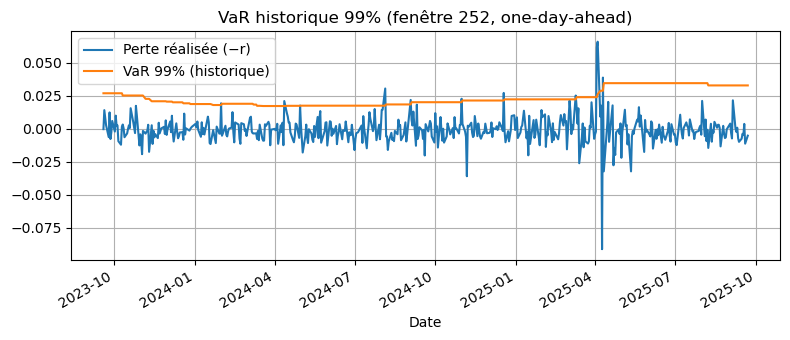

In [32]:
# ============================================================
# VaR historique 99% (1-day-ahead) — portefeuille simple (4 titres)
# Tickers demandés : AAPL, MSFT, JPM, XOM (poids égaux)
# Prérequis (une fois) : pip install yfinance
# ============================================================

import pandas as pd
import numpy as np
import yfinance as yf
# import matplotlib.pyplot as plt  # (optionnel pour tracer)

# --- Paramètres ---
tickers = ["AAPL","MSFT","JPM","XOM"]
START_DATE = "2020-01-01"
END_DATE = None  # jusqu'à aujourd'hui
alpha_tail = 0.01   # 1% → VaR 99%
window = 252        # ~1 an boursier

# --- Téléchargement des prix ajustés ---
data = yf.download(
    tickers,
    start=START_DATE, end=END_DATE,
    interval="1d", progress=False, auto_adjust=False
)

# Extraire 'Adj Close' (gère le MultiIndex)
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
prices = prices[tickers].dropna(how="all")  # ne garder que les 4 tickers

# --- Rendements (log) ---
ret = np.log(prices).diff().dropna()

# --- Portefeuille équipondéré (poids égaux) ---
w = np.repeat(1/len(tickers), len(tickers))
port_r = ret.dot(w)

# -- VaR historiqu-e 99% (fenêtre glissante, prévision t+1) ---
var_99 = -port_r.rolling(window).quantile(alpha_tail).shift(1).dropna()  # perte positive (≥ 0)

# --- Sortie principale ---
print("Dernière date VaR_99% :", var_99.index[-1].date())
print("VaR_99% (historique, 1j) :", f"{100*var_99.iloc[-1]:.2f}%")

# (Option) Visualisation sur ~2 ans :
loss = (-port_r).loc[var_99.index]  # pertes positives
last_n = 2*252
plt.figure(figsize=(8,3.5))
loss.iloc[-last_n:].plot(label="Perte réalisée (−r)")
var_99.iloc[-last_n:].plot(label="VaR 99% (historique)")
plt.legend(); plt.title("VaR historique 99% (fenêtre 252, one-day-ahead)")
plt.tight_layout(); plt.show()
